# Comparing raster data for regions of interest

In this notebook we compare our 30m resolution rasters of risk with those from the Wildfire Risk to Communities (WRC) project. We visualize regions where the two datasets strongly differ, as well as regions of historical significance (e.g. previous urban conflagrations). These comparisons showcase examples of why the datasets differ and explain patterns of how those differences propagate into CONUS-wide variations.

In [10]:
import geopandas as gpd
import icechunk
import matplotlib.pyplot as plt
import xarray as xr
from shapely import Point

from ocr import catalog

Load in the raster level data.

In [2]:
version = '0.13.0'
storage = icechunk.s3_storage(
    bucket='carbonplan-ocr',
    prefix=f'output/fire-risk/tensor/production/v{version}/ocr.icechunk',
    from_env=True,
)
repo = icechunk.Repository.open(storage)
session = repo.readonly_session('main')

ds = xr.open_dataset(session.store, engine='zarr', chunks={})
ds

<xarray.Dataset> Size: 652GB
Dimensions:                     (latitude: 97579, longitude: 208881)
Coordinates:
  * latitude                    (latitude) float64 781kB 22.43 22.43 ... 52.48
  * longitude                   (longitude) float64 2MB -128.4 -128.4 ... -64.05
Data variables:
    USFS_RPS                    (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    burn_probability_2011       (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    burn_probability_usfs_2011  (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    burn_probability_2047       (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    burn_probability_usfs_2047  (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    conditional_risk_usfs       (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    wind_risk_2047              (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    wind_risk_2011              (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>

In [11]:
# Load wind direction distribution for this region
wind_dist = (
    catalog.get_dataset('conus404-ffwi-p99-wind-direction-distribution-30m-4326')
    .to_xarray()
    .wind_direction_distribution
)

In [3]:
tracts_dict = {}
for statistic in ['corr_low', 'low_bias', 'high_bias']:
    tracts_dict[statistic] = gpd.read_file(f'{statistic}_tracts_{version}.shp', index_col=0)

/opt/coiled/env/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option INDEX_COL
  return ogr_read(
/opt/coiled/env/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option INDEX_COL
  return ogr_read(
/opt/coiled/env/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option INDEX_COL
  return ogr_read(


In [4]:
states = gpd.read_file('s3://carbonplan-risks/shapefiles/cb_2018_us_state_20m.zip')
states = states[~(states['STUSPS'].isin(['AK', 'PR', 'HI']))]

In [5]:
var_name_dict = {'corr_low': 'low correlation', 'high_bias': 'high bias', 'low_bias': 'low bias'}

In [41]:
def plot_regions_two_datasets(
    ds,
    wind_dist,
    bounding_box,
    title,
    ds1_title='CarbonPlan',
    ds2_title='Scott (2024)',
    points_to_plot=None,
    vlims=None,
):
    fig = plt.figure(figsize=(16, 8))
    # create a 2x8 grid, so the bottom row can have 8 equal panels
    gs = fig.add_gridspec(nrows=2, ncols=8, height_ratios=[1, 1], hspace=0.35, wspace=0.35)

    # first row: 3 panels that span the 8 columns
    ax_top1 = fig.add_subplot(gs[0, 0:3])
    ax_top2 = fig.add_subplot(gs[0, 3:6])
    ax_top3 = fig.add_subplot(gs[0, 6:8])

    # second row - 8 panels for the wind directions
    axes_bottom = [fig.add_subplot(gs[1, i]) for i in range(8)]

    if vlims is not None:
        cax = ds.wind_risk_2011.plot(ax=ax_top1, vmin=vlims[0], vmax=vlims[1])
    else:
        cax = ds.wind_risk_2011.plot(ax=ax_top1)
    ax_top1.set_title(ds1_title)
    ds.USFS_RPS.plot(ax=ax_top2, vmin=cax.get_clim()[0], vmax=cax.get_clim()[1])
    ax_top2.set_title(ds2_title)
    states.plot(ax=ax_top3, color='white', edgecolor='black')
    if points_to_plot is None:
        gpd.GeoSeries(Point(bounding_box[1].start, bounding_box[0].start)).set_crs(
            'EPSG:4326'
        ).centroid.plot(ax=ax_top3)
    else:
        points_to_plot.centroid.plot(ax=ax_top3)

    # Row 2: Wind direction distribution for all 8 directions
    # wind is indexed w.r.t. the winds from CONUS404 which are indexed as 0 is from the north, 1 is from the northeast
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    for i, ax in enumerate(axes_bottom):
        # only add colorbar to rightmost plot
        if i == 7:
            add_colorbar = True
        else:
            add_colorbar = False
        wind_dist.sel(
            latitude=bounding_box[0],
            longitude=bounding_box[1],
            wind_direction=i,
        ).plot(ax=ax, cmap='viridis', vmin=0, vmax=1, add_colorbar=add_colorbar)
        ax.set_title(f'Wind from\nDirection: {directions[i]}')
    for ax in [ax_top1, ax_top2, ax_top3] + axes_bottom:  # axes is an array from plt.subplots(...)
        ax.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False,
        )
        ax.set_xlabel('')
        ax.set_ylabel('')
    if title is not None:
        plt.suptitle(title, fontsize='xx-large')

    plt.tight_layout()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## Areas where datasets are poorly correlated

By plotting the census tracts with the lowest correlations we see the two main causes of low agreement:
1. The influence of wind, in which we preferentially spread risk in some places while WRC uniformly spreads it. We'll call this "wind effect". This can either increase or decrease the risk values depending on whether the wind is smearing the burn probability preferentially away from or toward developed areas.
1. The WRC project's underlying burn probability maps decrease burn probability in many developed areas. This is visible in maps where Scott has more detailed spatial structure in contrast to our blurrier maps. We'll call this the "development effect". This only contributes to a high bias in our data with respect to Scott (2024).

In [44]:
tracts_dict['corr_low'].index

RangeIndex(start=0, stop=10, step=1)

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


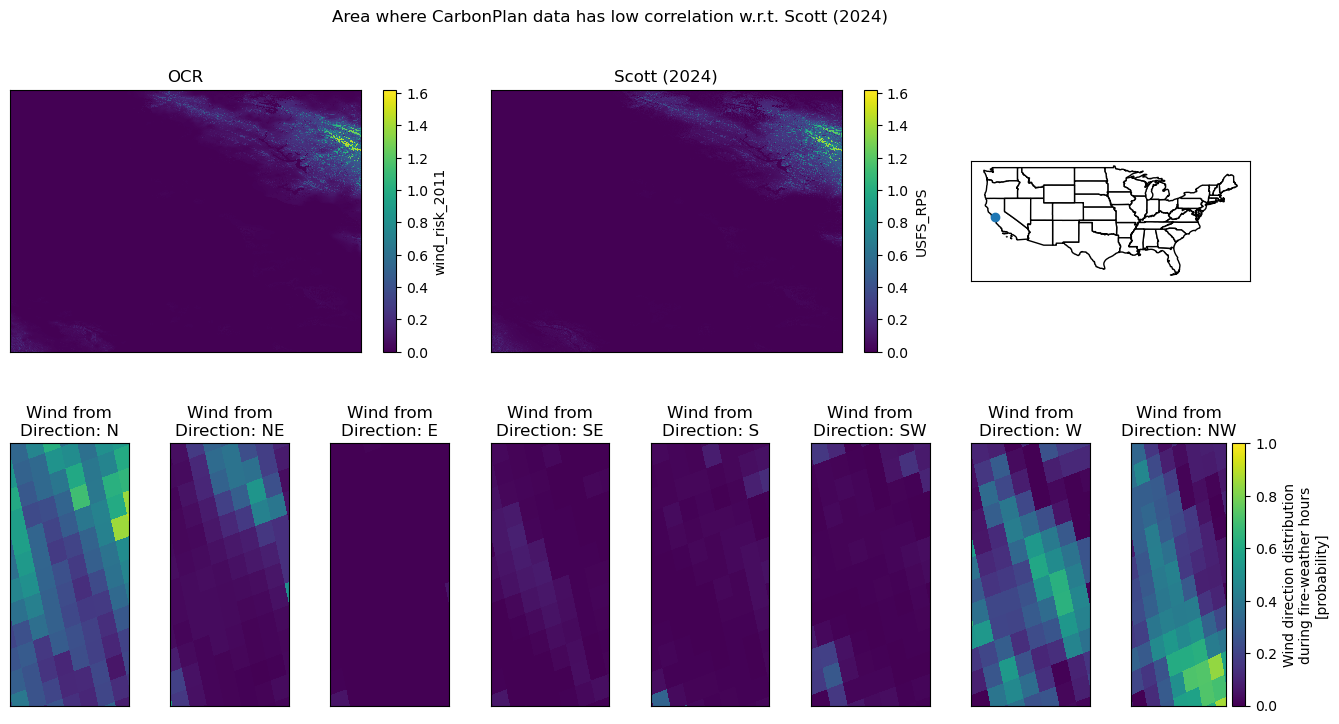

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


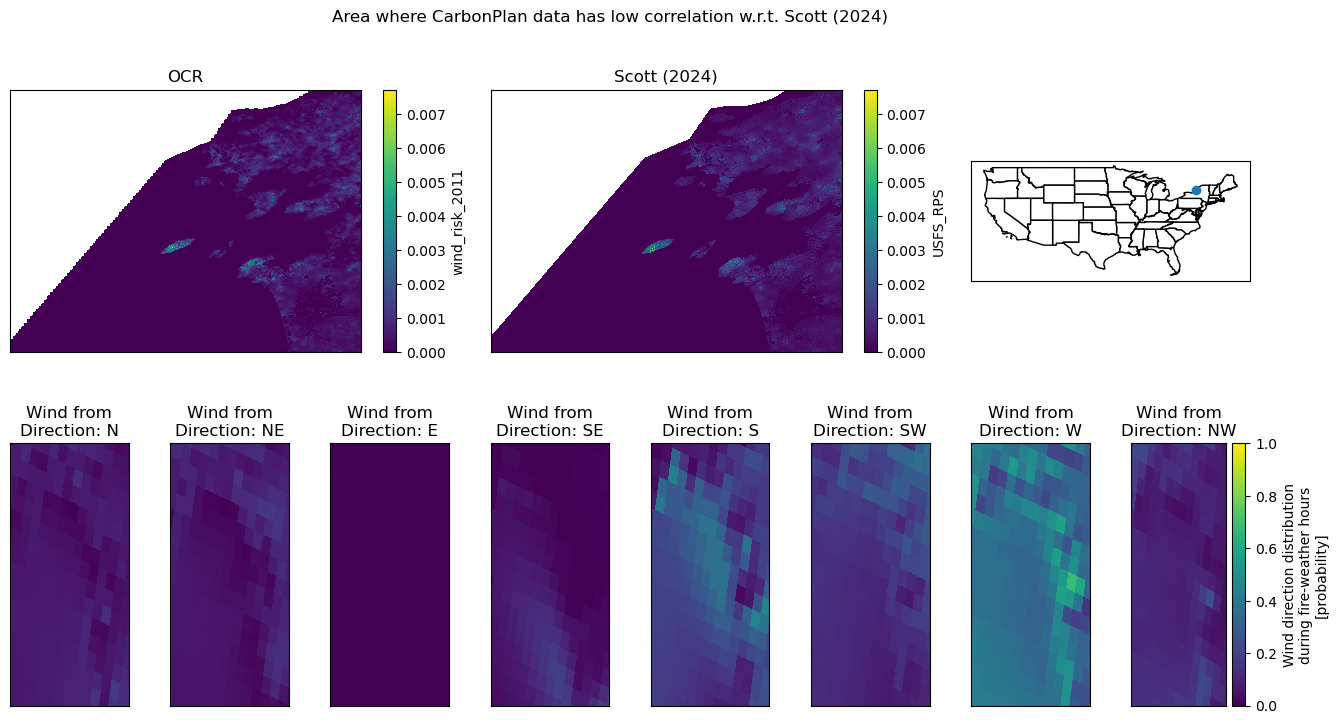

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


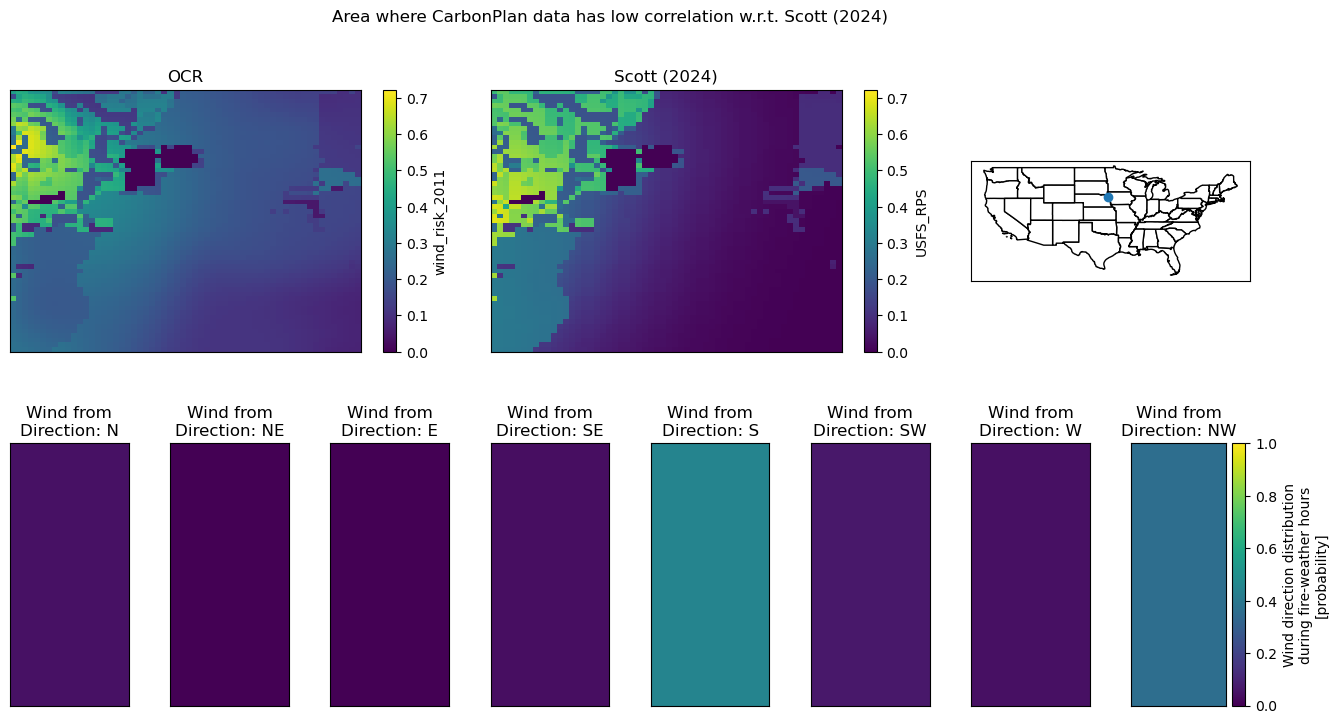

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


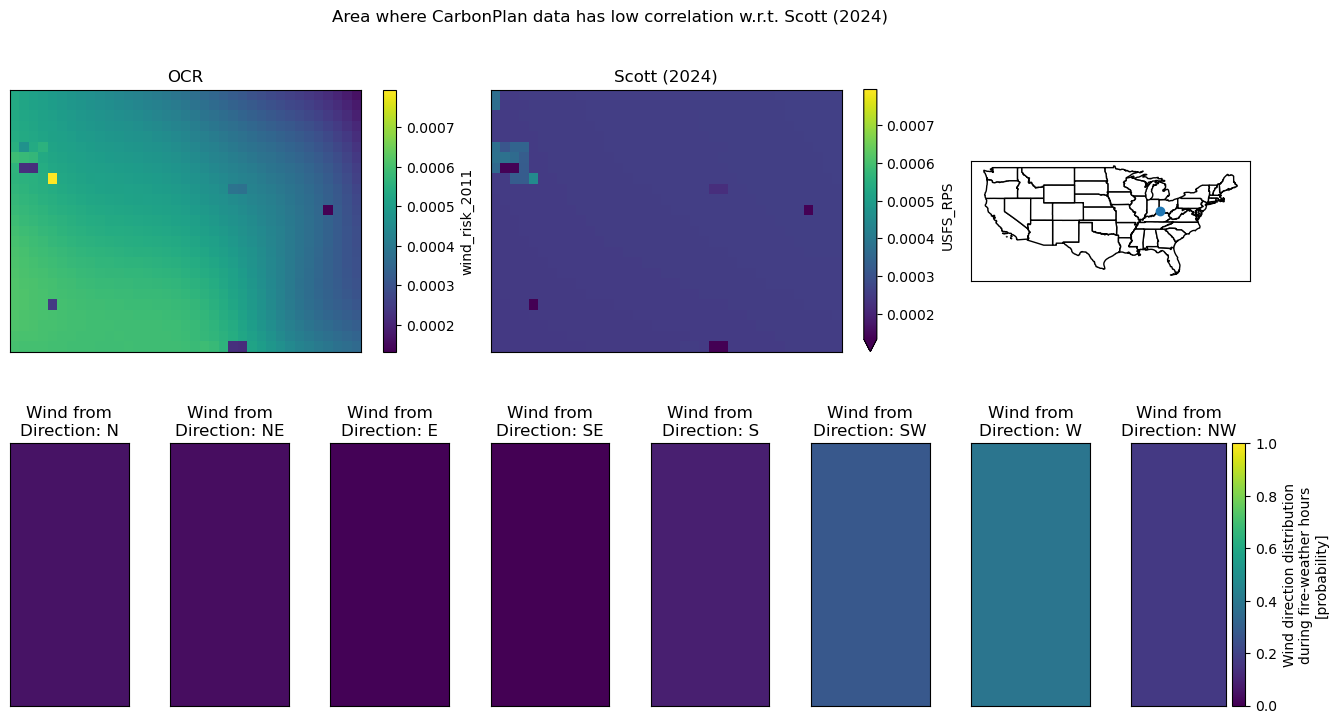

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


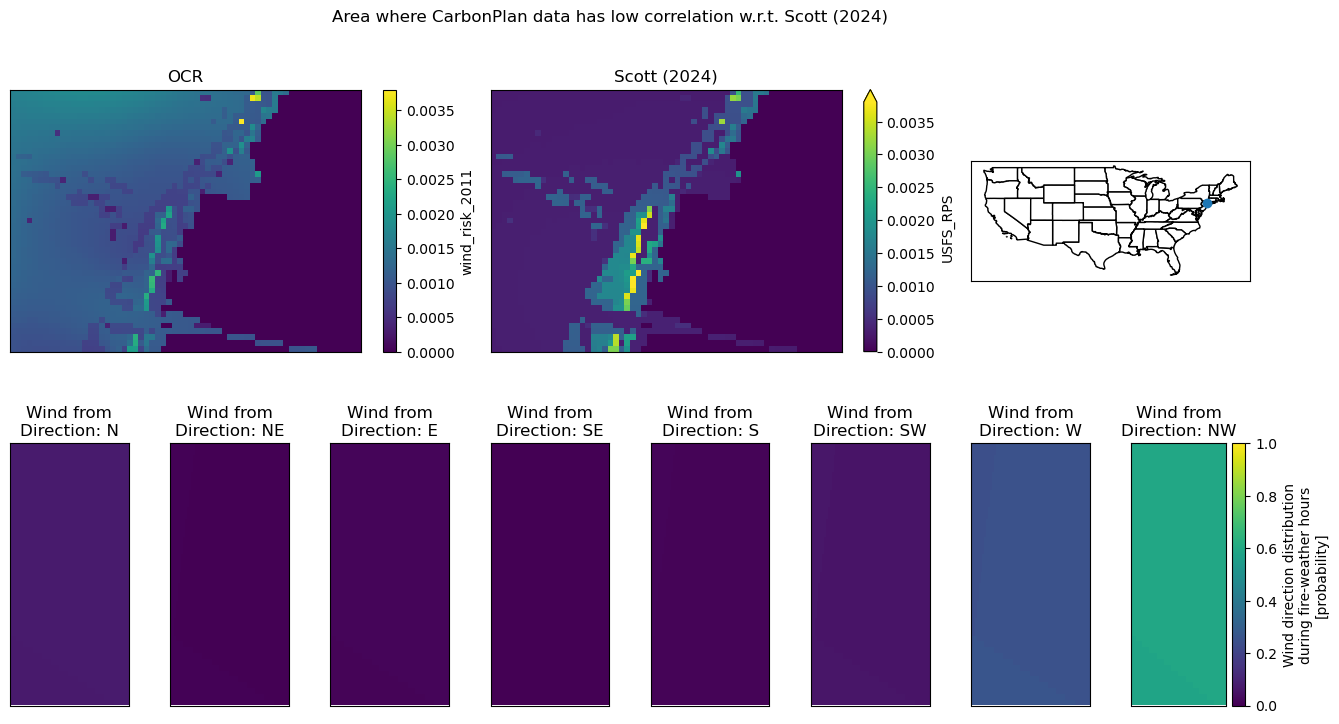

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


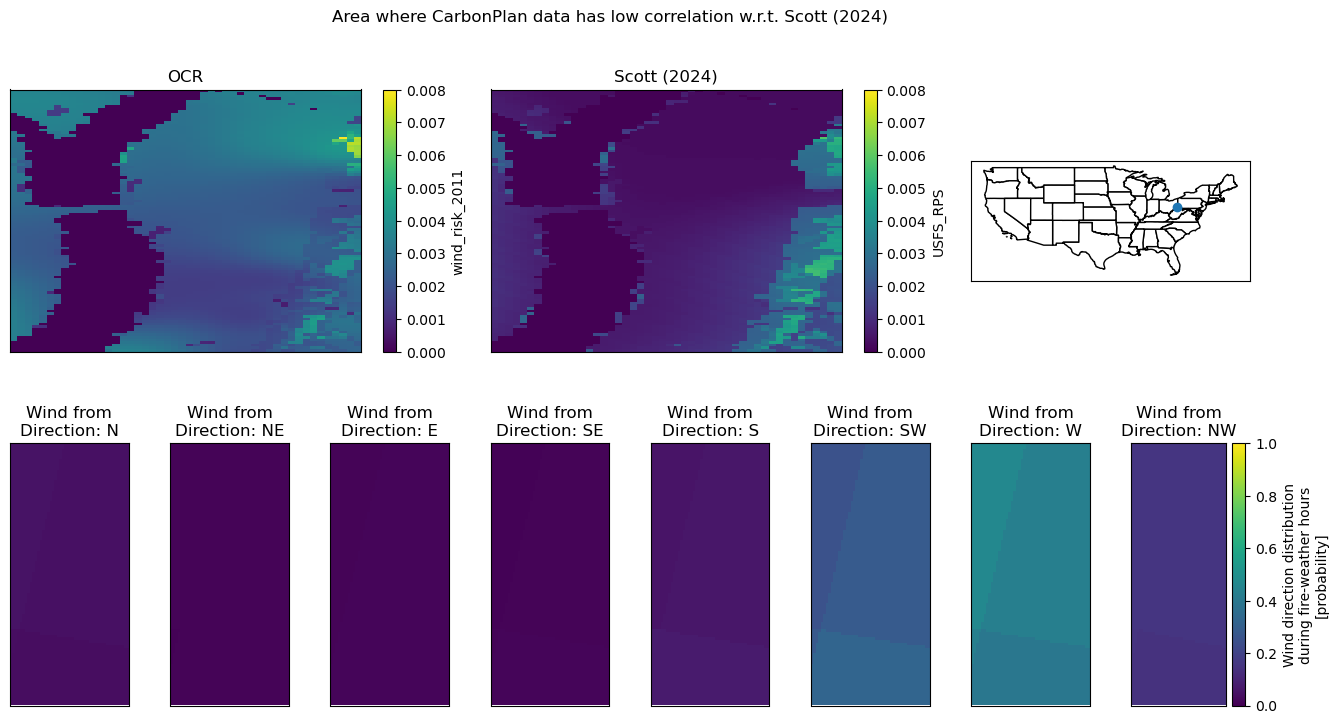

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


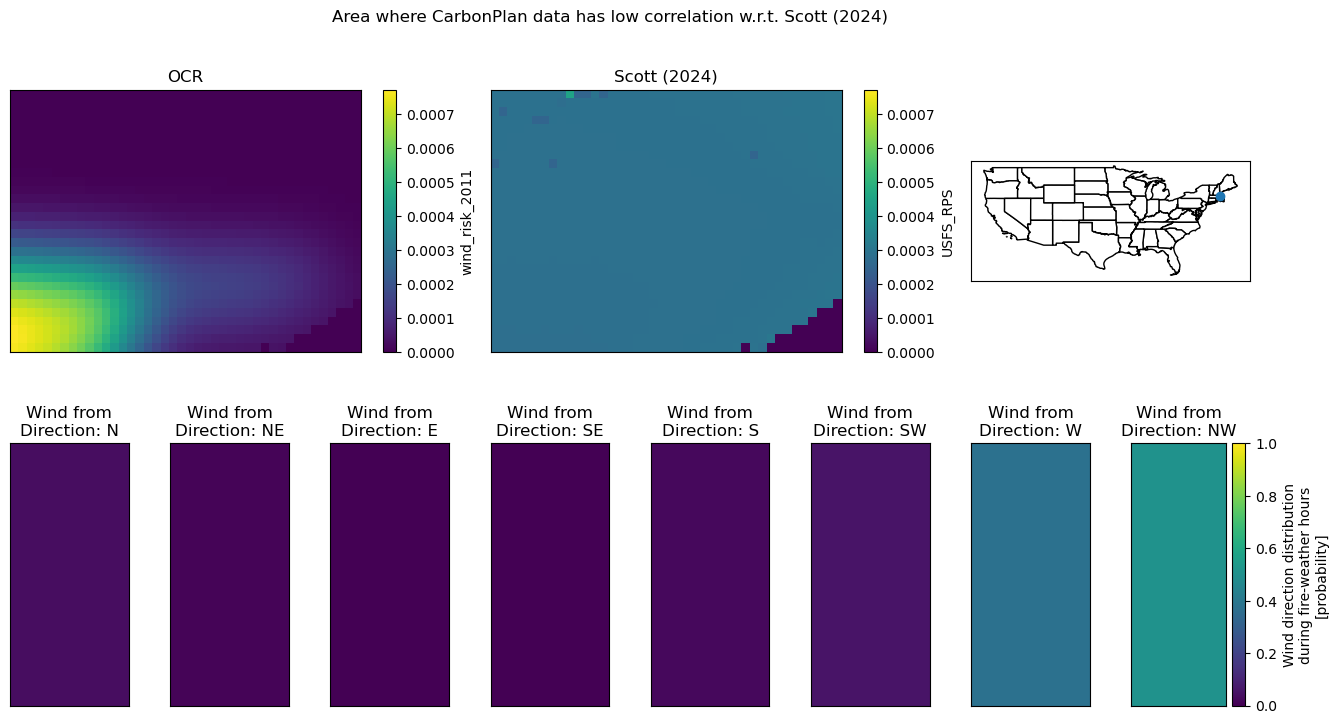

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


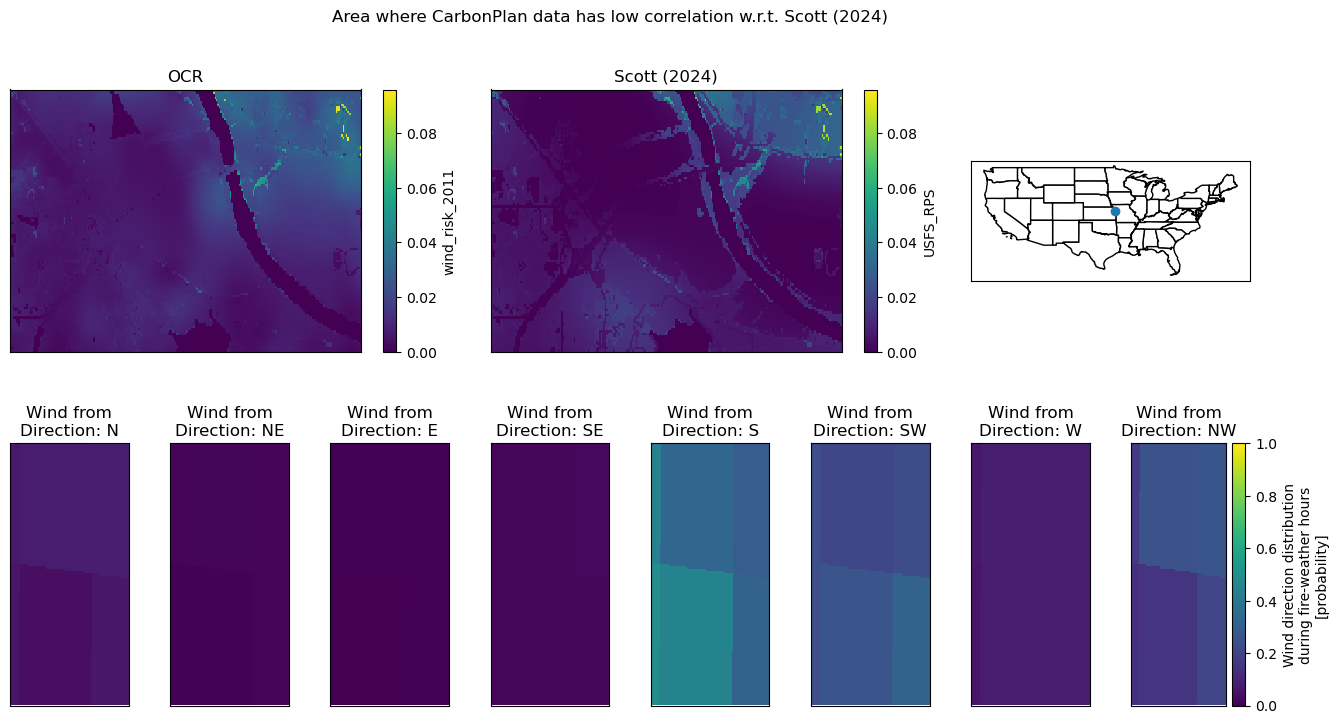

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


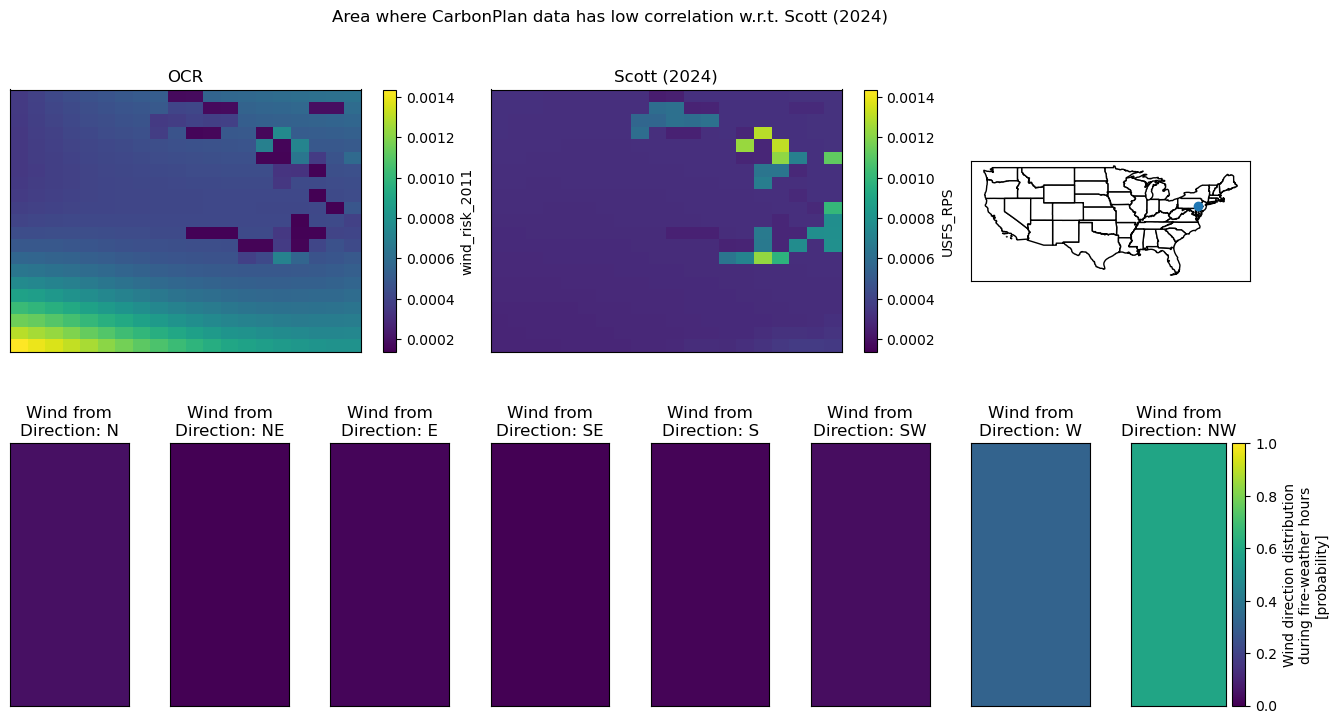

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


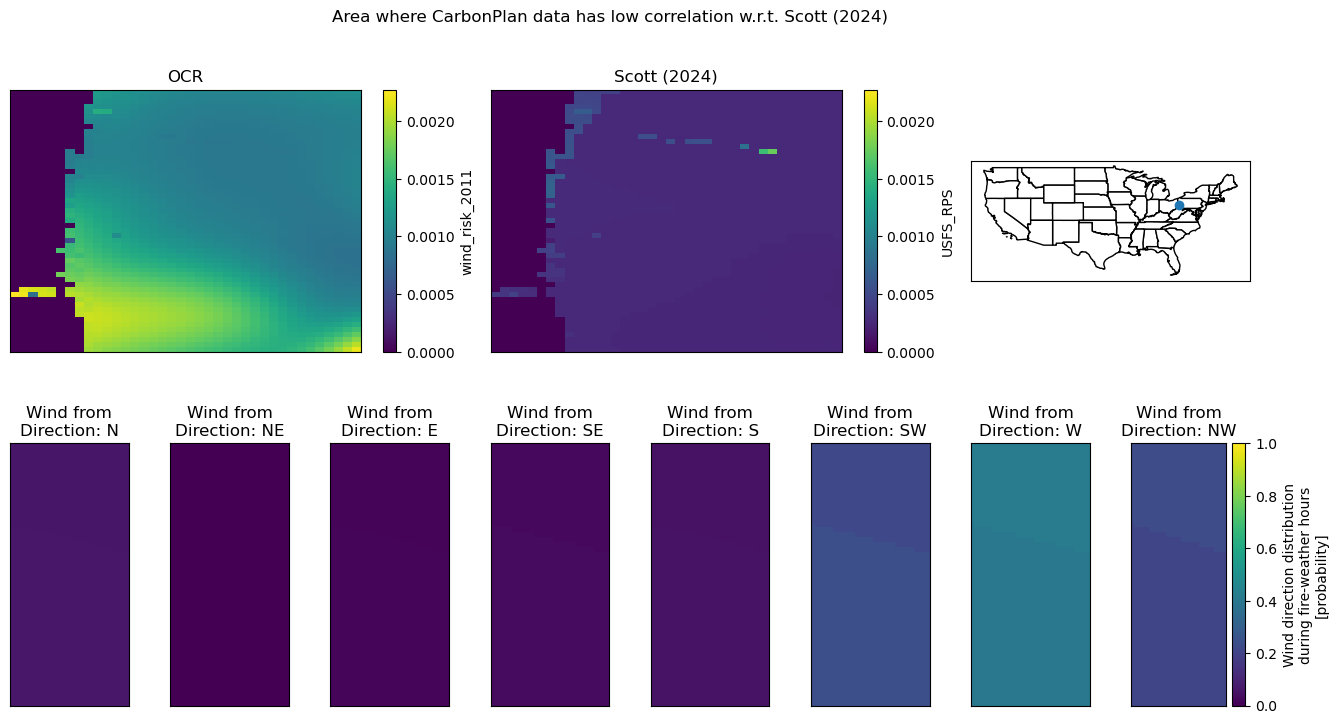

In [45]:
for statistic in ['corr_low']:
    for index in tracts_dict['corr_low'].index:
        bounds = tracts_dict['corr_low'].loc[[index]].bounds
        bounding_box = [
            slice(bounds.loc[index].miny, bounds.loc[index].maxy),
            slice(bounds.loc[index].minx, bounds.loc[index].maxx),
        ]
        plot_regions_two_datasets(
            ds.sel(latitude=bounding_box[0], longitude=bounding_box[1]),
            wind_dist,
            bounding_box,
            f'Area where CarbonPlan data has {var_name_dict[statistic]} w.r.t. Scott (2024)',
            points_to_plot=tracts_dict['corr_low'].loc[[index]].centroid,
            ds1_title='OCR',
        )

## Areas where we are high-biased with respect to Scott et al. (2024)

As with the plots of areas of low correlation above, we see strong high biases in places where both the wind effect and the development effect are at play. The third row below shows an example of where spatial artifacts from the underlying conditional risk to potential structures (CRPS). This is because our higher burn probability (elevated due to the wind effect), makes them visible in our data while they are washed out in the Scott et al. (2024) data.

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


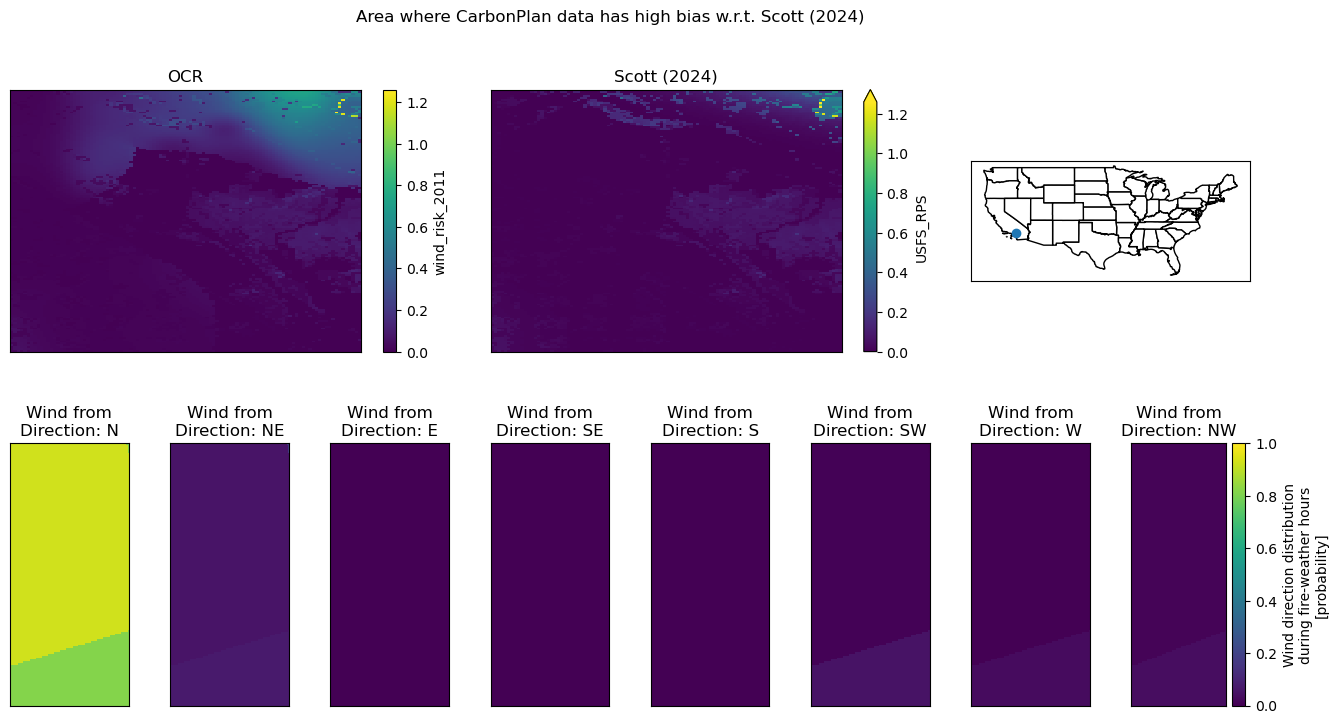

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


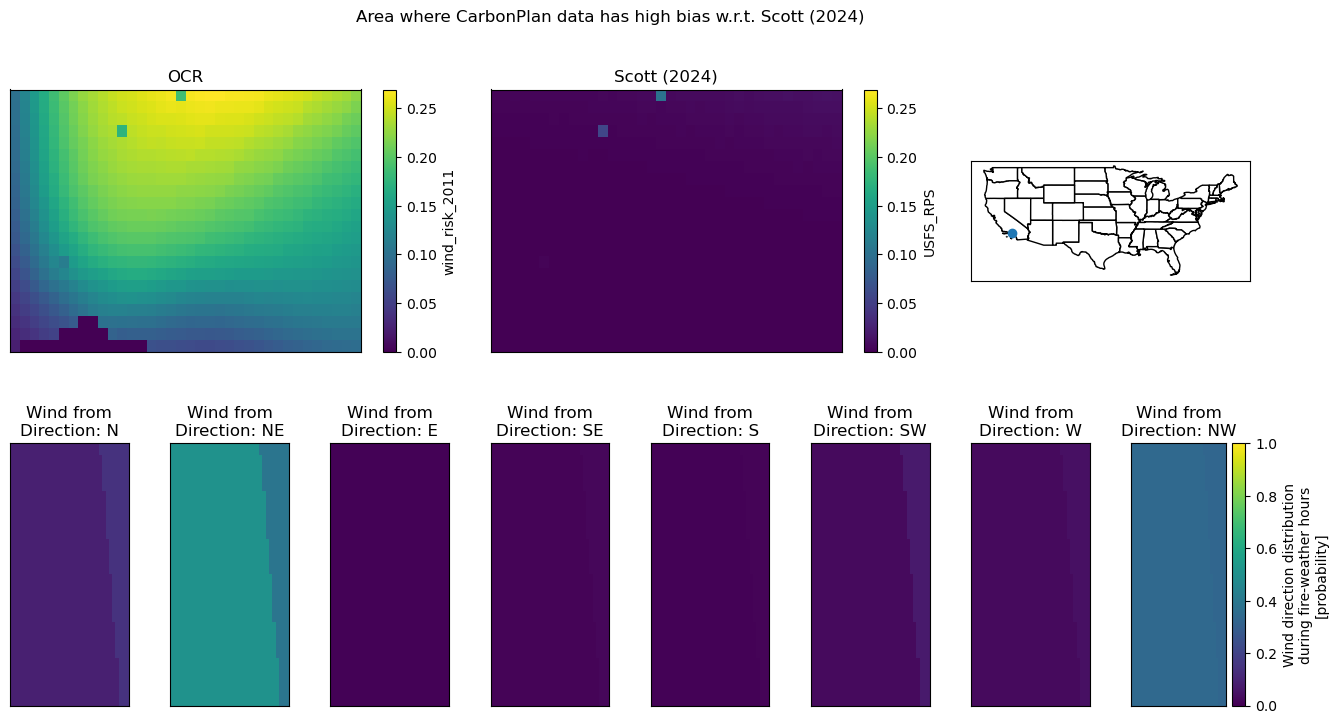

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


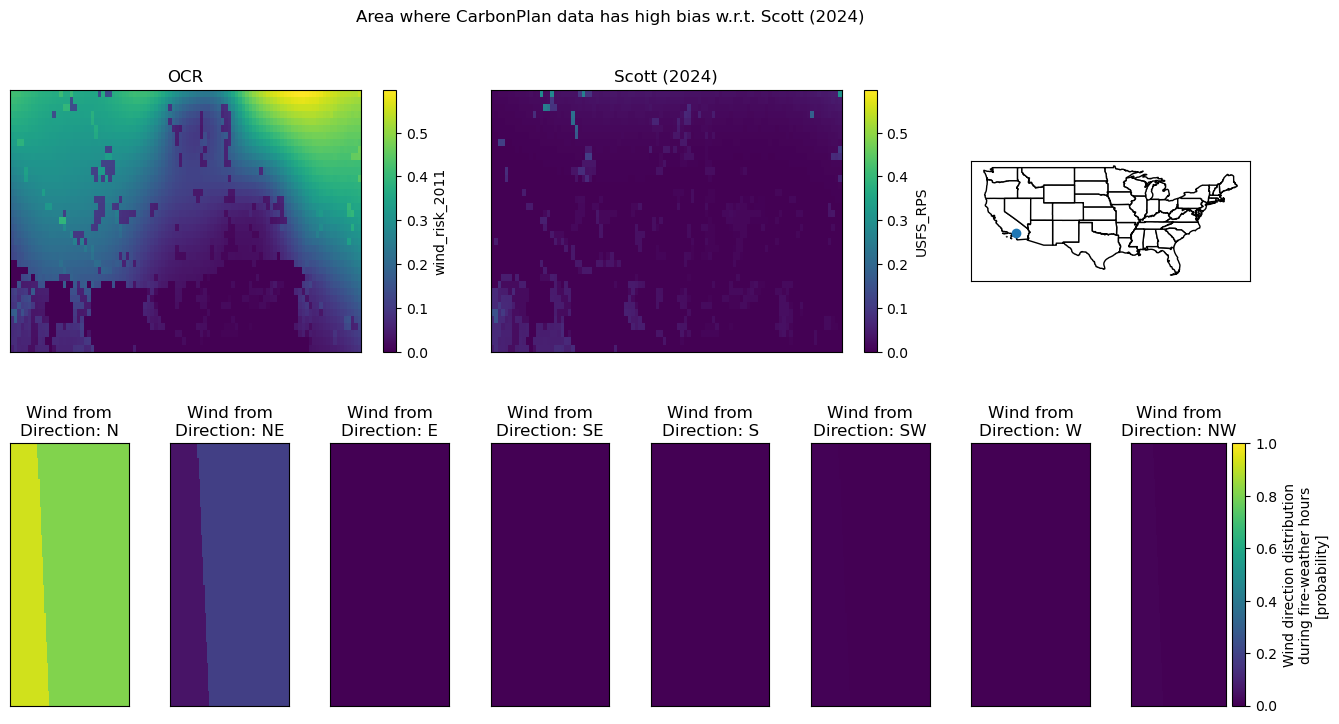

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


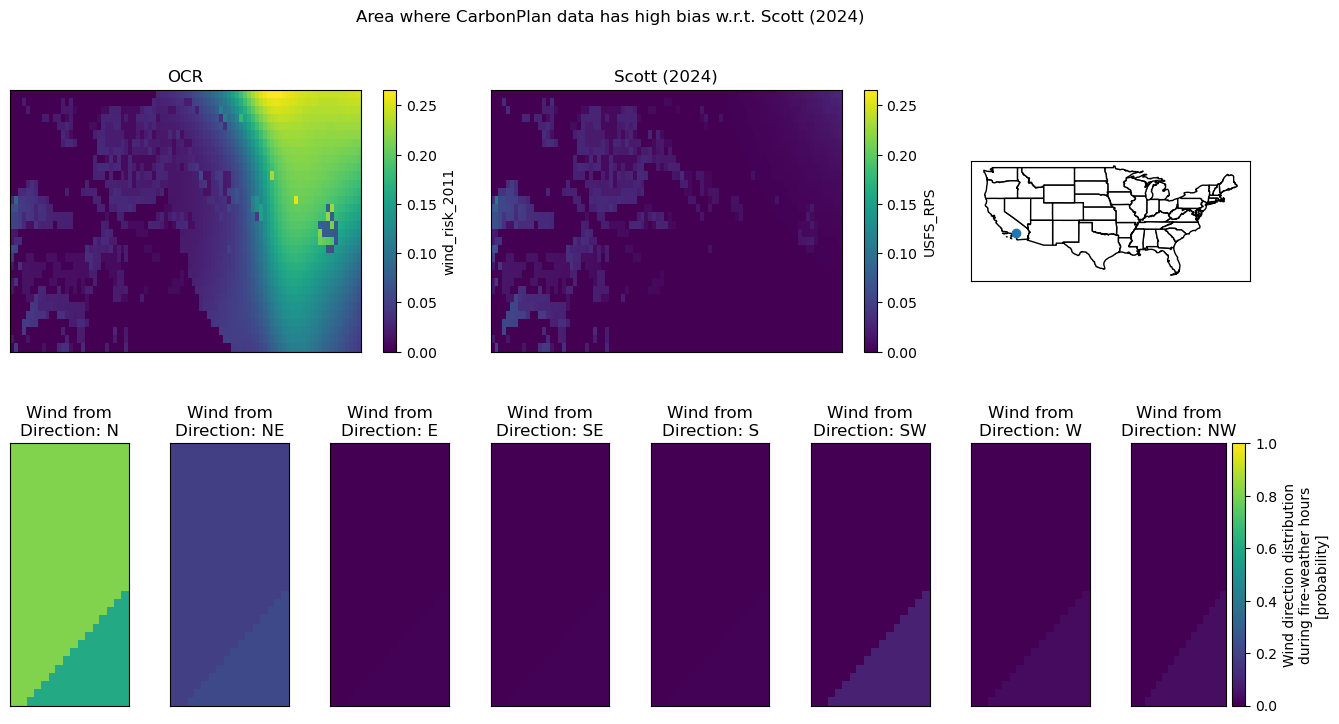

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


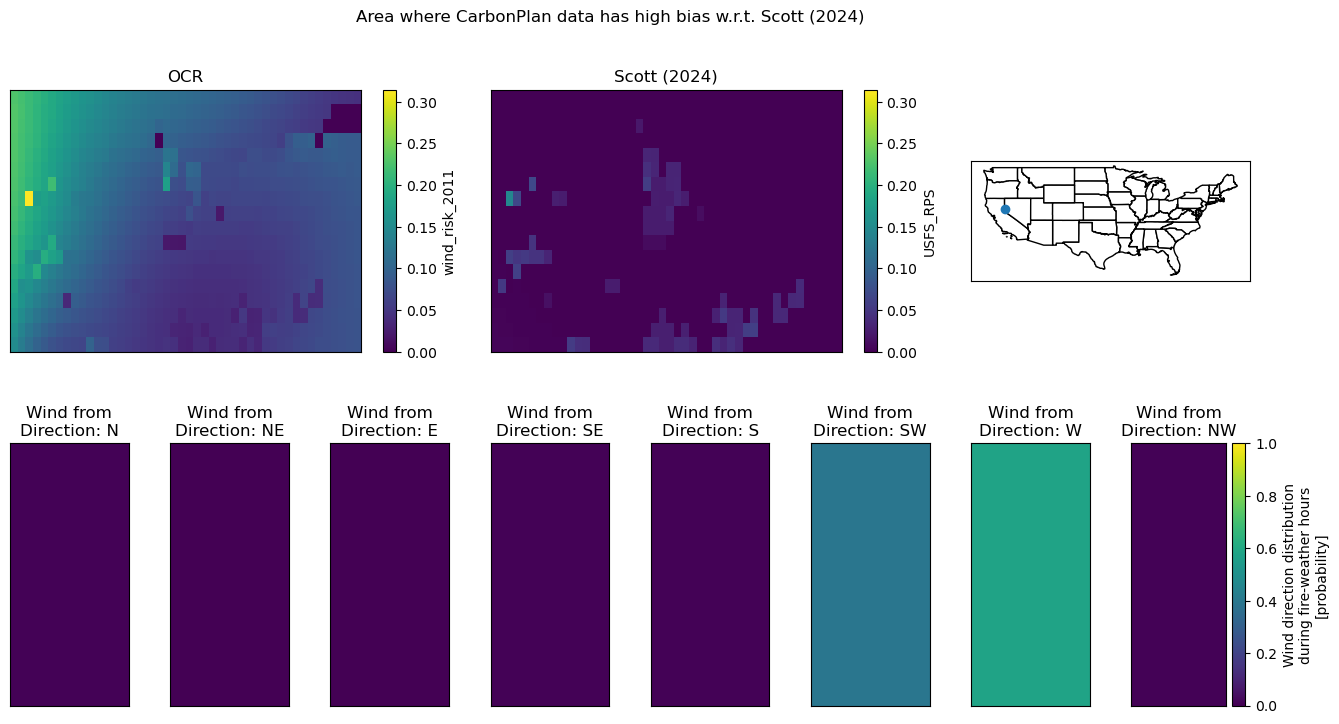

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


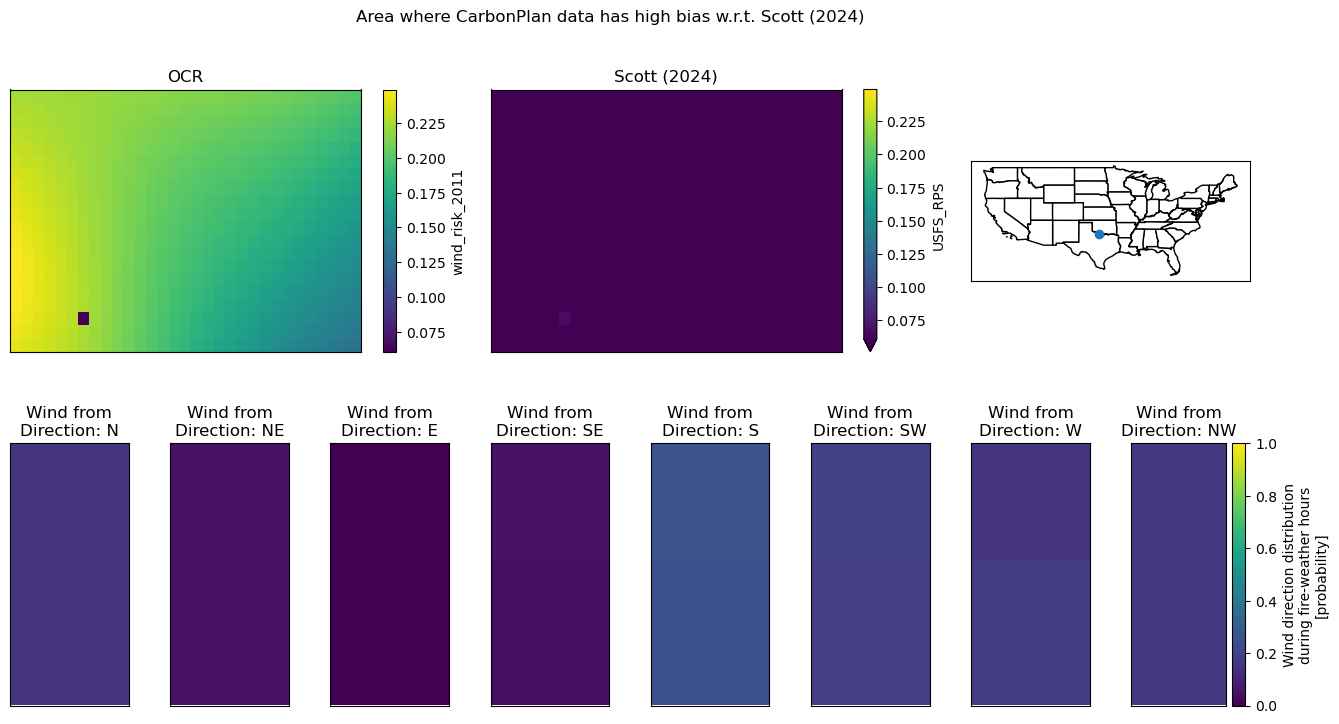

In [49]:
for statistic in ['high_bias']:
    for index in tracts_dict[statistic].index:
        bounds = tracts_dict[statistic].loc[[index]].bounds
        bounding_box = [
            slice(bounds.loc[index].miny, bounds.loc[index].maxy),
            slice(bounds.loc[index].minx, bounds.loc[index].maxx),
        ]
        plot_regions_two_datasets(
            ds.sel(latitude=bounding_box[0], longitude=bounding_box[1]),
            wind_dist,
            bounding_box,
            f'Area where CarbonPlan data has {var_name_dict[statistic]} w.r.t. Scott (2024)',
            points_to_plot=tracts_dict[statistic].loc[[index]].centroid,
            ds1_title='OCR',
        )

## Areas where we are low-biased with respect to Scott et al. (2024)

The develoment effect does not contribute to places where we are low-biased with respect to the Scott et al. (2024) data. Low-biased areas are places where our risk maps depict lower risk values because we preferentially spread burn probability away from developed areas.

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


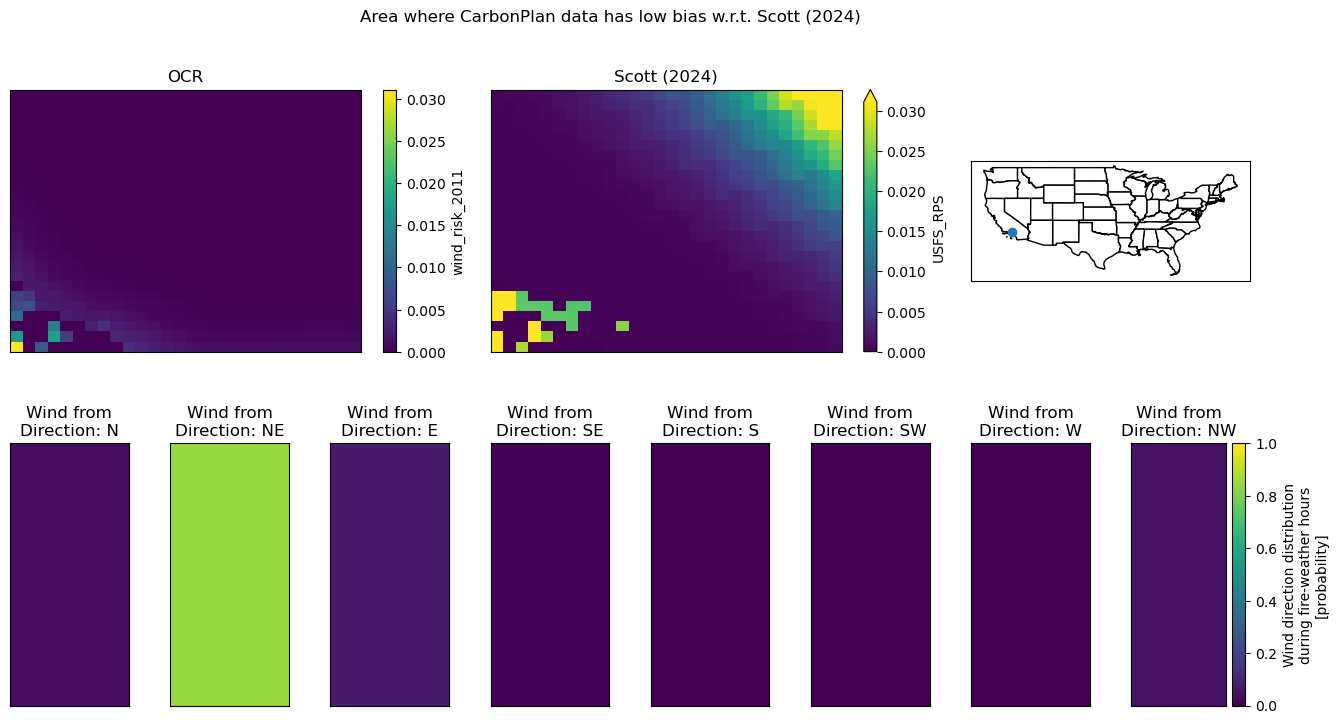

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


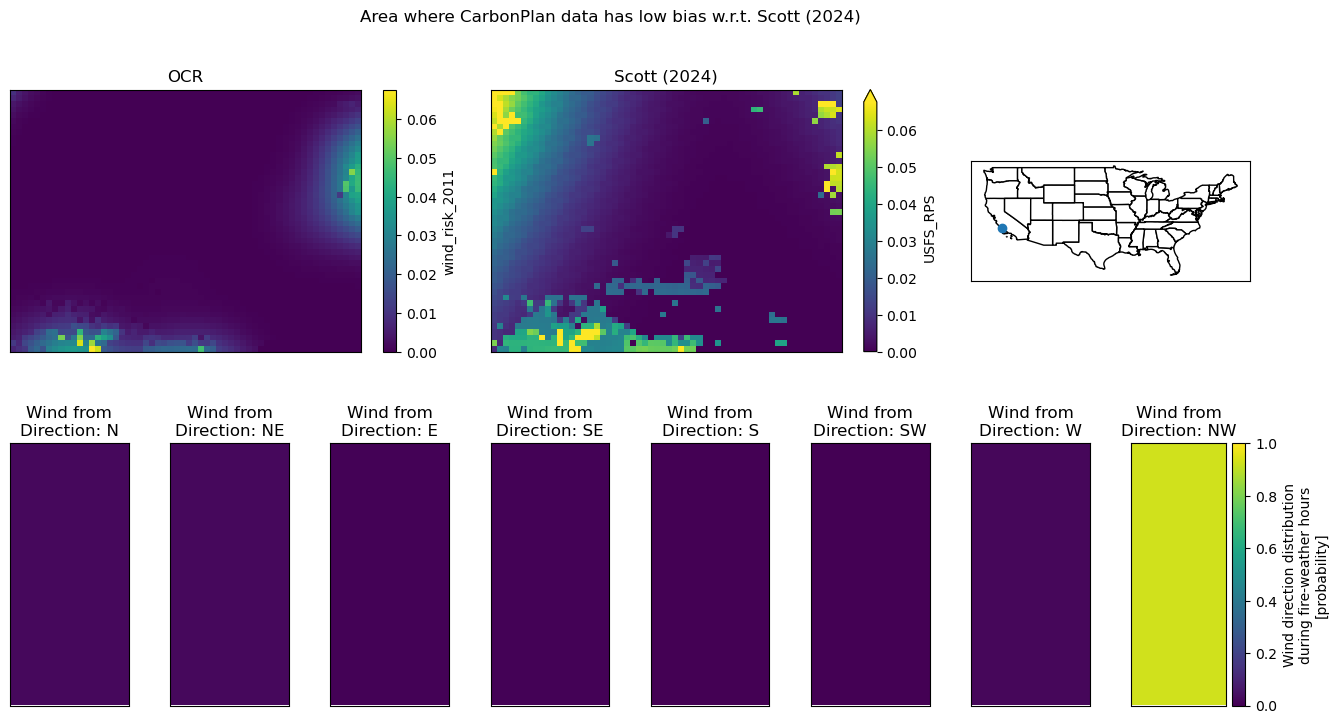

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


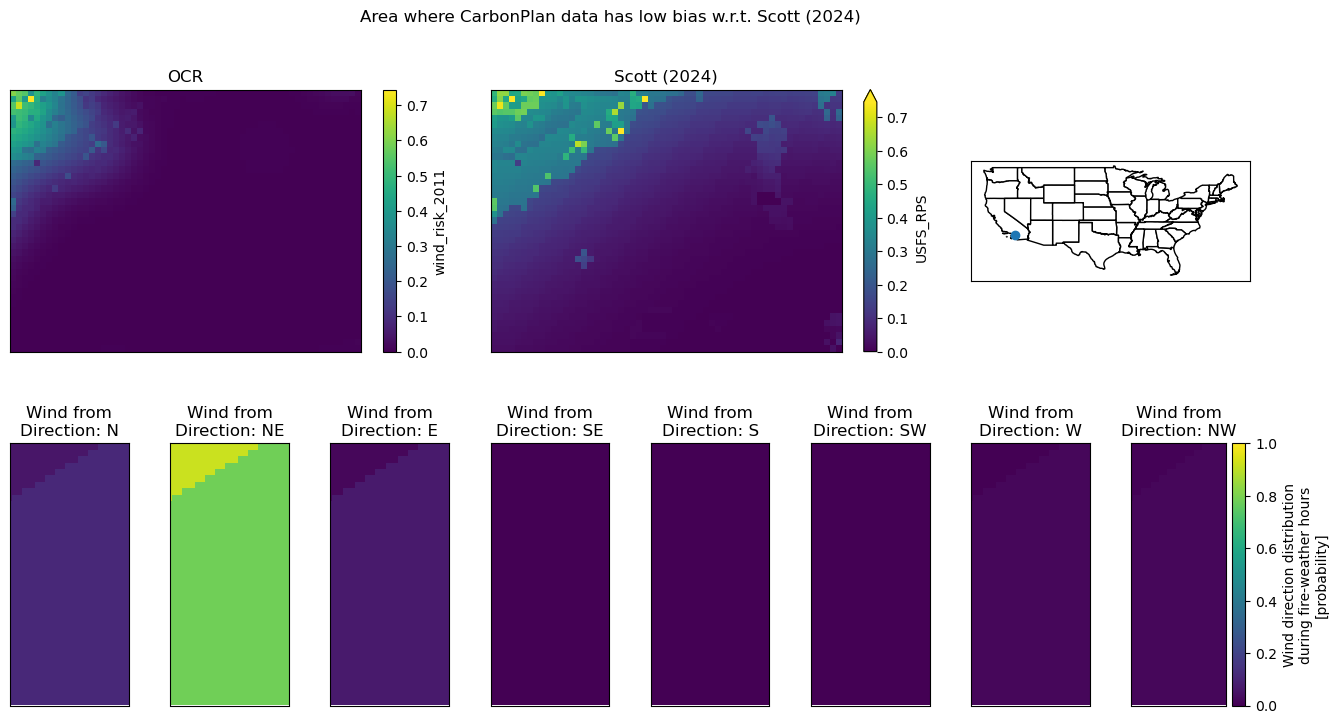

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


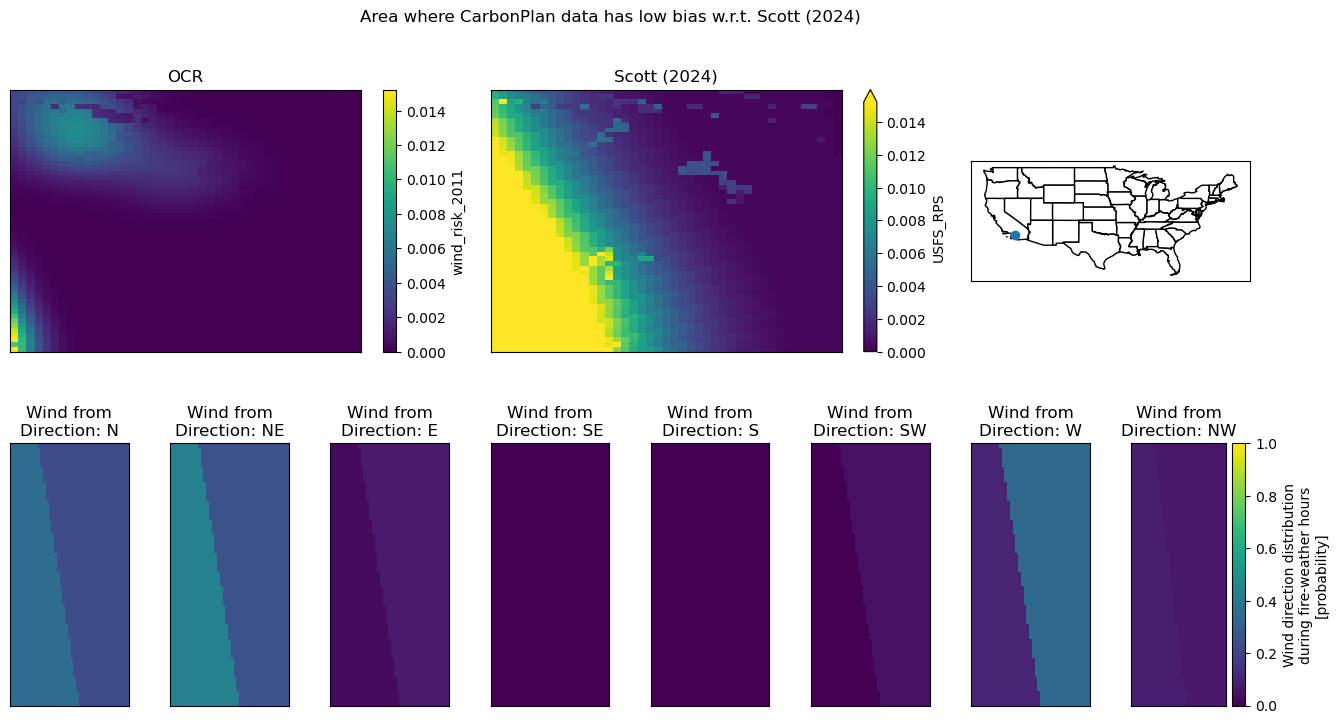

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


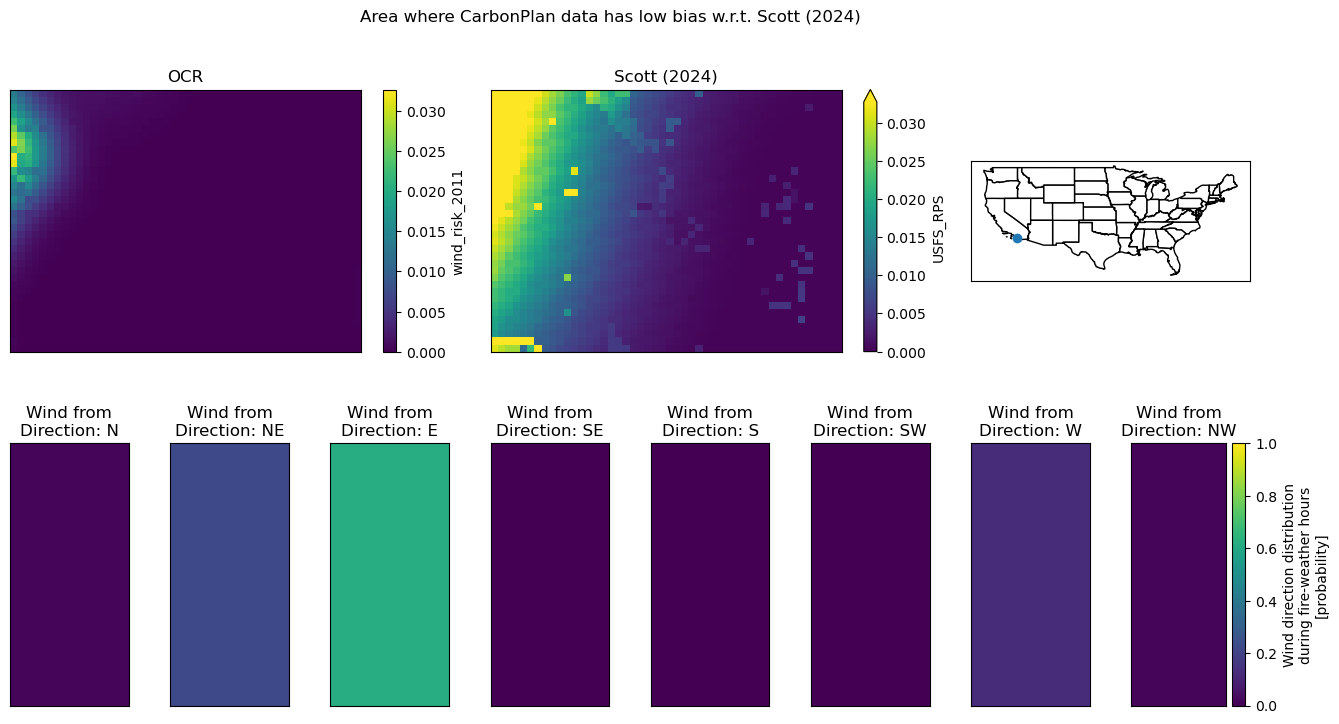

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


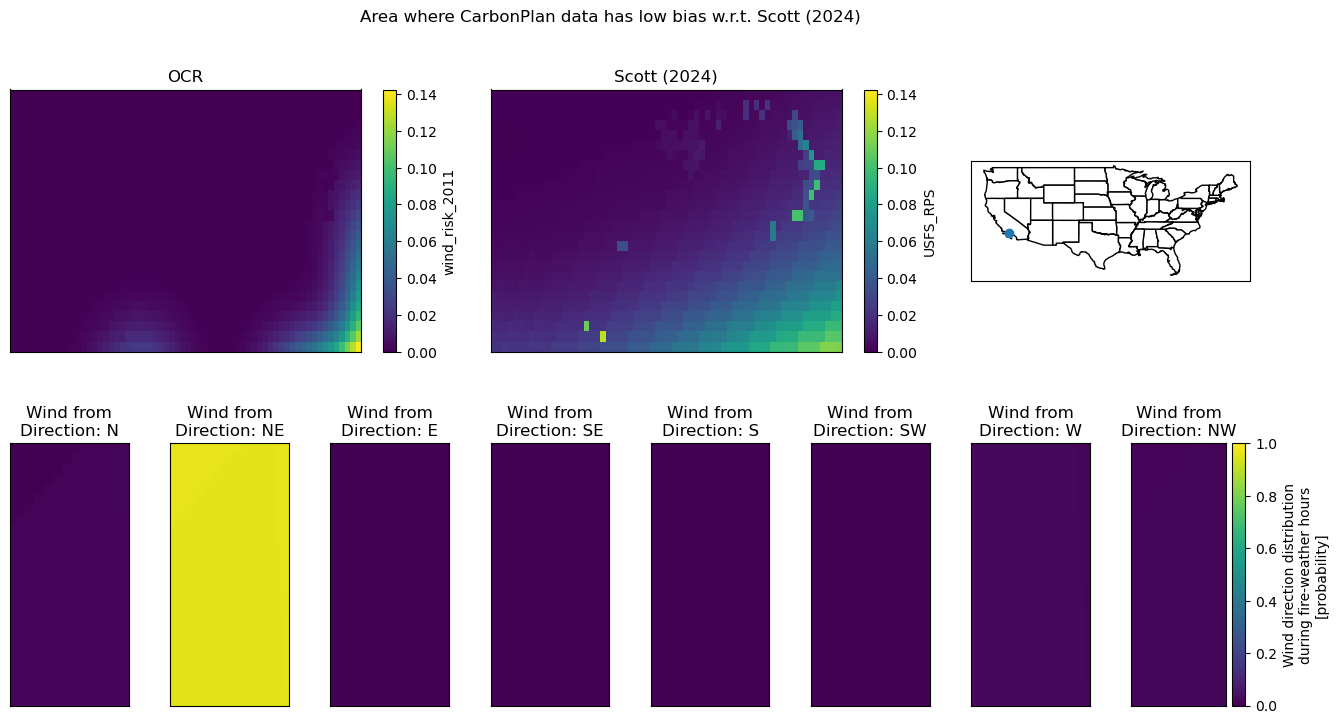

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


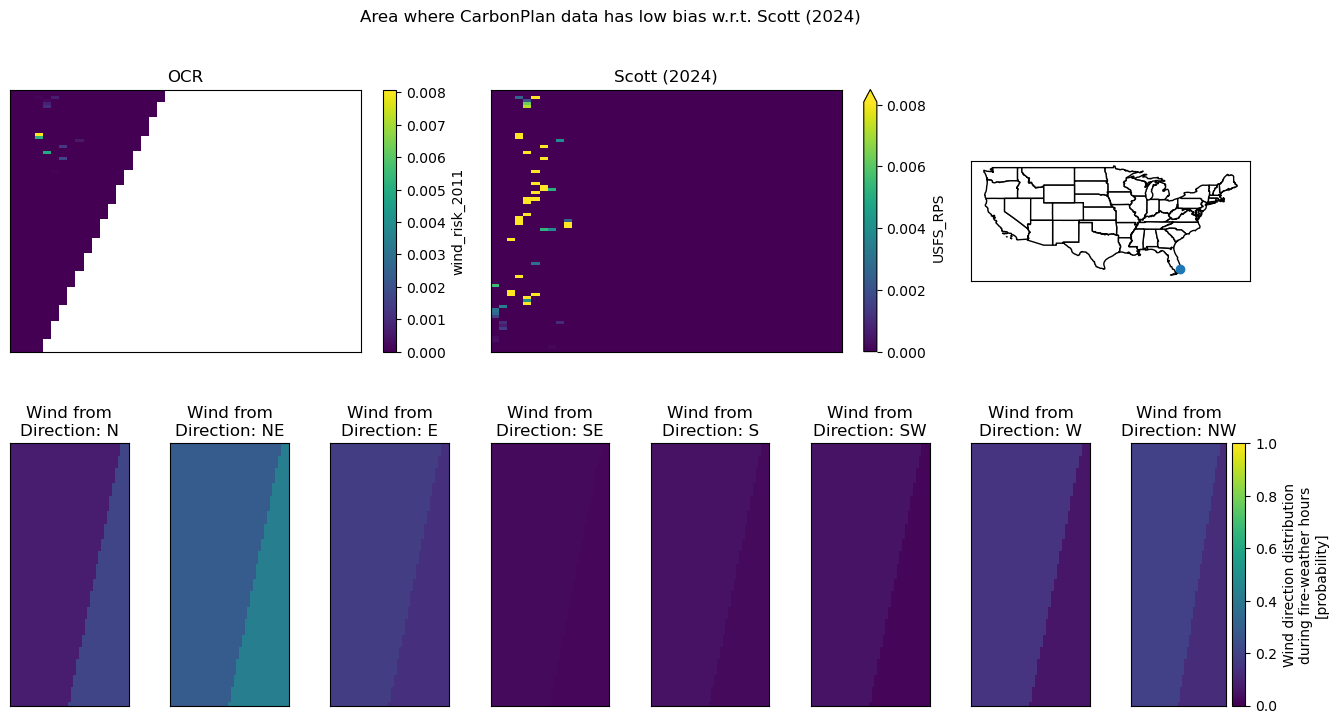

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


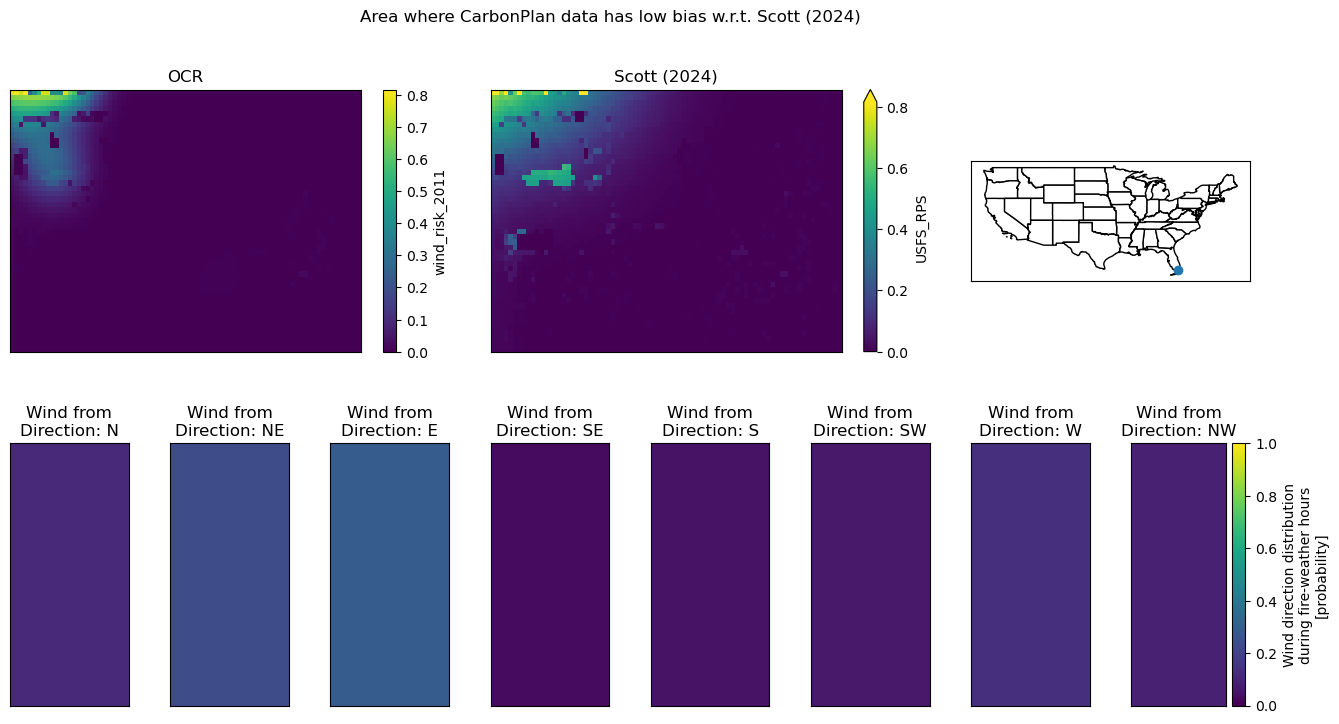

/tmp/ipykernel_1754/2828791912.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1754/2828791912.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


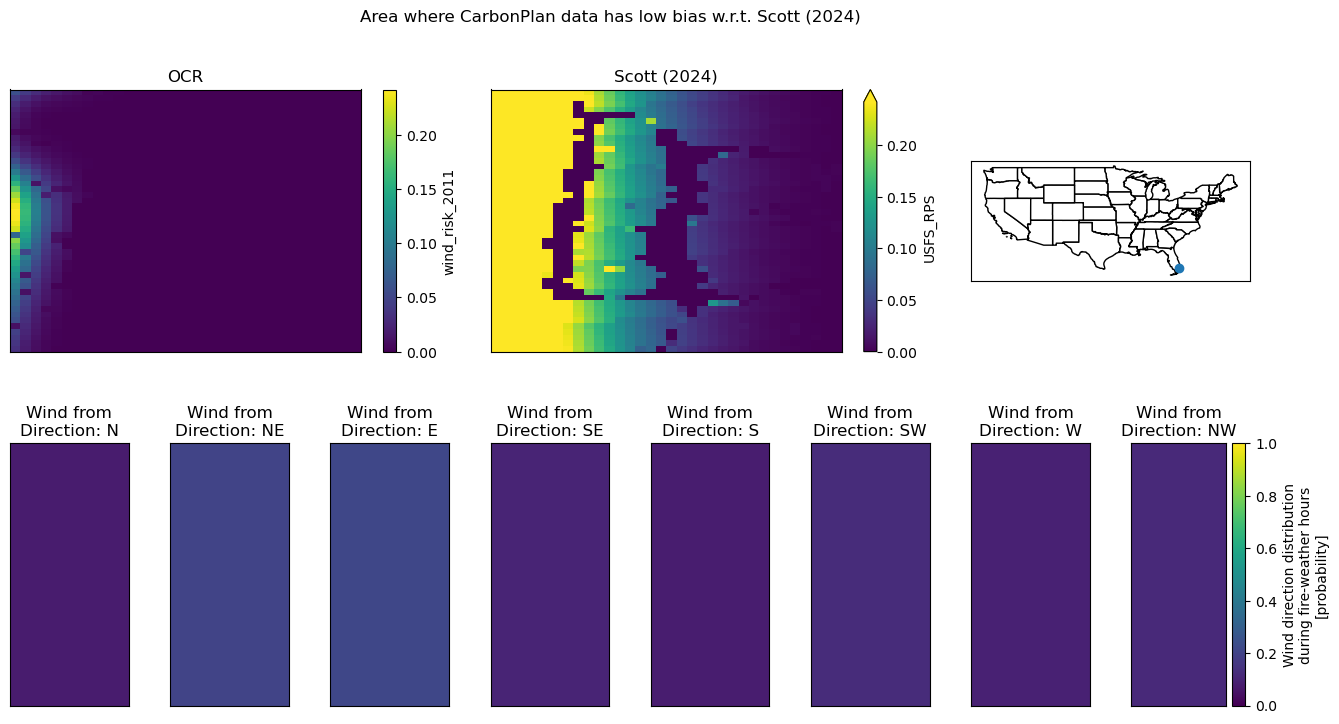

In [48]:
for statistic in ['low_bias']:
    for index in tracts_dict[statistic].index:
        bounds = tracts_dict[statistic].loc[[index]].bounds
        bounding_box = [
            slice(bounds.loc[index].miny, bounds.loc[index].maxy),
            slice(bounds.loc[index].minx, bounds.loc[index].maxx),
        ]
        plot_regions_two_datasets(
            ds.sel(latitude=bounding_box[0], longitude=bounding_box[1]),
            wind_dist,
            bounding_box,
            f'Area where CarbonPlan data has {var_name_dict[statistic]} w.r.t. Scott (2024)',
            points_to_plot=tracts_dict[statistic].loc[[index]].centroid,
            ds1_title='OCR',
        )

## Areas with historic fires

We look at three regions with historical urban conflagrations and we show how we have spread risk preferentially toward developed areas in those regions.

/tmp/ipykernel_299/3748588936.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ).centroid.plot(ax=axarr[2])


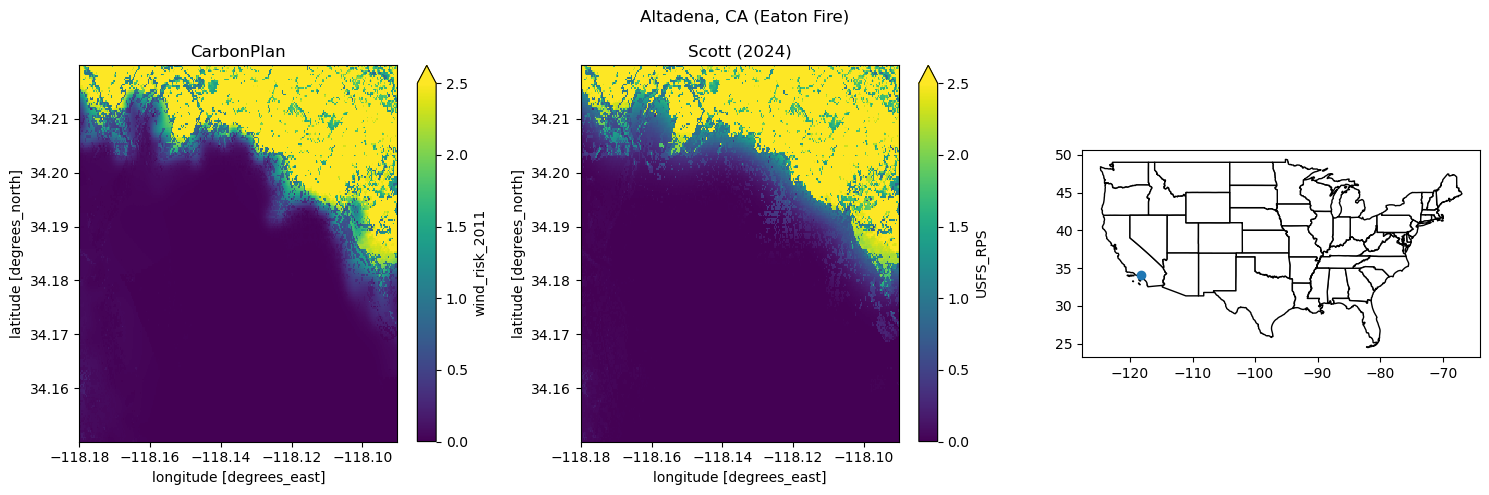

In [15]:
bounding_box = [slice(34.15, 34.22), slice(-118.18, -118.09)]
plot_regions_two_datasets(
    ds=ds.sel(latitude=bounding_box[0], longitude=bounding_box[1]),
    bounding_box=bounding_box,
    title='Altadena, CA (Eaton Fire)',
    vlims=[0, 2.5],
)

/tmp/ipykernel_299/3748588936.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ).centroid.plot(ax=axarr[2])


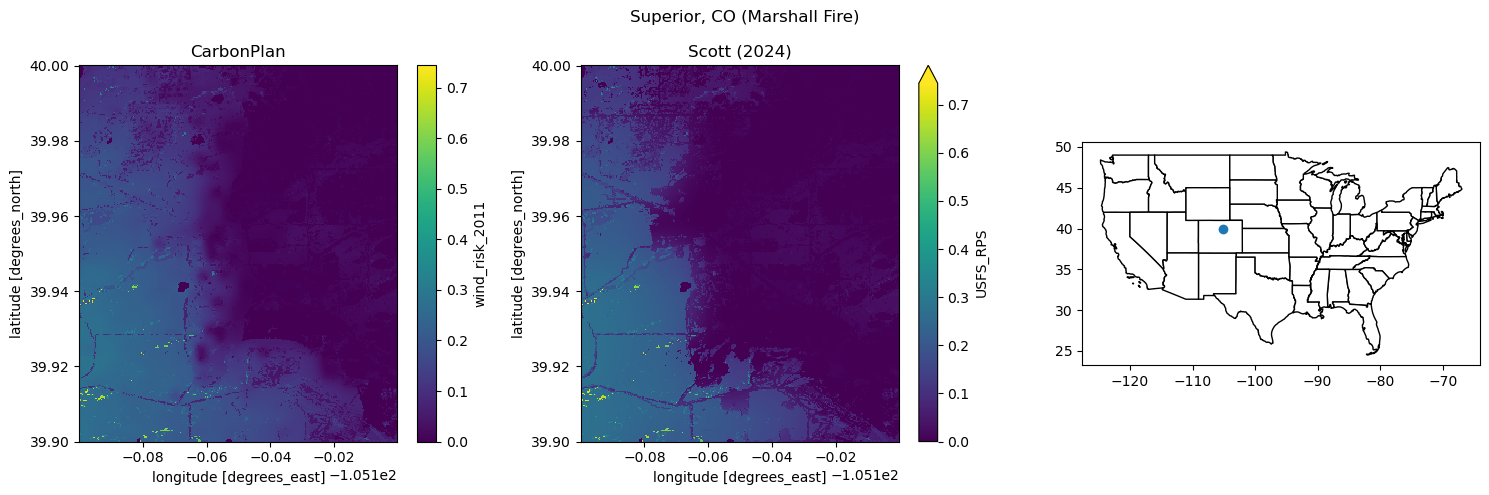

In [16]:
bounding_box = [slice(39.9, 40), slice(-105.2, -105.1)]
plot_regions_two_datasets(
    ds=ds.sel(latitude=bounding_box[0], longitude=bounding_box[1]),
    bounding_box=bounding_box,
    title='Superior, CO (Marshall Fire)',
    # vlims=[0,2.5]
)

/tmp/ipykernel_299/3748588936.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ).centroid.plot(ax=axarr[2])


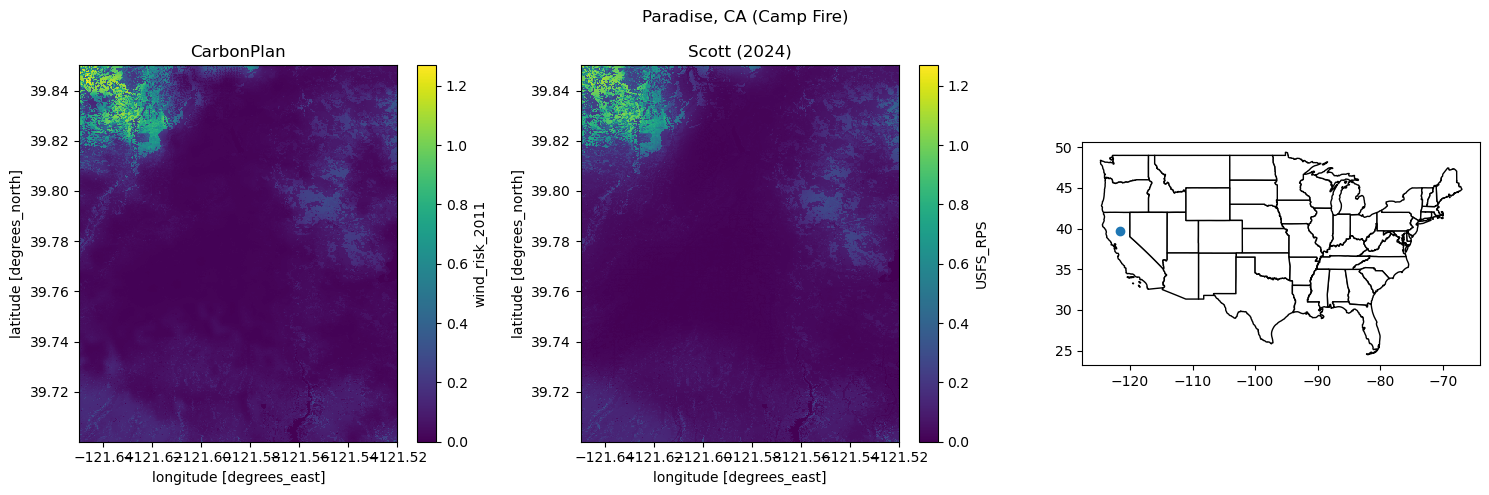

In [17]:
bounding_box = [slice(39.7, 39.85), slice(-121.65, -121.52)]
plot_regions_two_datasets(
    ds=ds.sel(latitude=bounding_box[0], longitude=bounding_box[1]),
    bounding_box=bounding_box,
    title='Paradise, CA (Camp Fire)',
    # vlims=[0,2.5]
)